In [1]:
import tensorflow as tf
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import numpy as np

def get_empty_series(steps):
    result = Series()
    for step in steps:
        result.add(step, 0)
    return result


class Series:
    def __init__(self):
        self.values = []
        self.steps = []

    def add(self, step, val):
        """ Insert step and value. Maintain sorted w.r.t. steps """
        if len(self.steps) == 0:
            self.steps.append(step)
            self.values.append(val)
        else:
            for idx in reversed(range(len(self.steps))):
                if step > self.steps[idx]:
                    break
            else:
                idx = -1
            self.steps.insert(idx + 1, step)
            self.values.insert(idx + 1, val)

    def verify(self):
        for i in range(len(self.steps) - 1):
            assert self.steps[i] <= self.steps[i + 1]

    def to_dict(self):
        self.verify()
        return {'steps': self.steps,
                'values': self.values}

def get_empty_series(steps):
    result = Series()
    for step in steps:
        result.add(step, 0)
    return result


def parse_tb_event_files(event_dir, tags=None):
    data = {}
    event_files = [os.path.join(event_dir, fname) for fname in os.listdir(event_dir)
                   if 'events.' in fname and not os.path.isdir(fname)]
    print('Found {} event file'.format(len(event_files)))
    for event_file in event_files:
        for e in tf.compat.v1.train.summary_iterator(event_file):
            for v in e.summary.value:
                tag = v.tag.replace('/', '_')
                if tags is None or tag in tags:
                    if data.get(tag) is None:
                        data[tag] = Series()
                    data[tag].add(step=e.step, val=v.simple_value)
    for tag in data:
        data[tag].verify()
        steps = data[tag].steps

    if tags is not None:
        for tag in tags:
            if tag not in data:
                data[tag] = get_empty_series(steps)
    return data

Found 1 event file
Found 1 event file
Found 1 event file
Found 1 event file
Found 1 event file
pearson coeffcient LB TRE_no_mean: (-0.6390786776655464, 4.3202979972662444e-20)
pearson coeffcient LB MI: (0.6936673074902159, 1.0306257718256061e-24)
pearson coeffcient LB TRE: (0.5491485487629086, 3.194337715763978e-14)
pearson coeffcient MI TRE_no_mean: (-0.3903976678410419, 2.579596476608091e-07)
pearson coeffcient TRE TRE_no_mean: (-0.11525970231049808, 0.14289365679369478)
pearson coeffcient MI TRE: (0.8329522007771024, 3.1507386139656274e-43)


<Figure size 432x288 with 0 Axes>

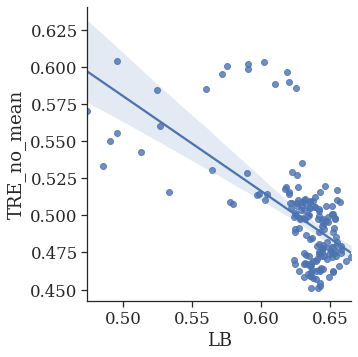

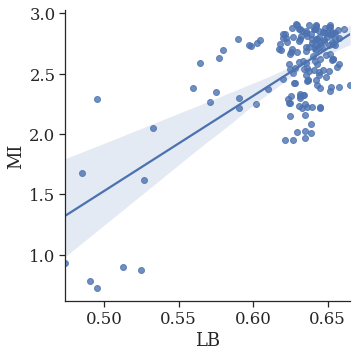

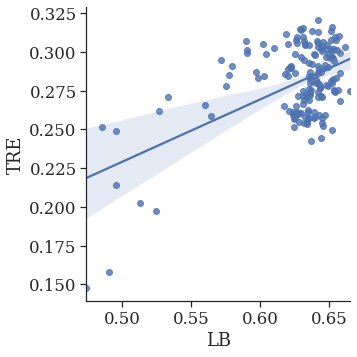

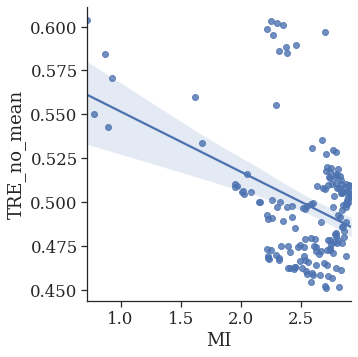

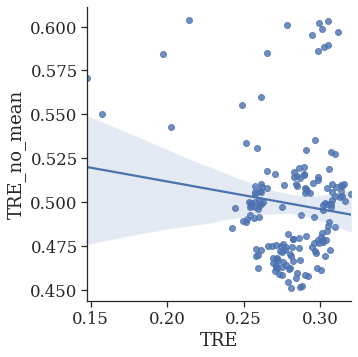

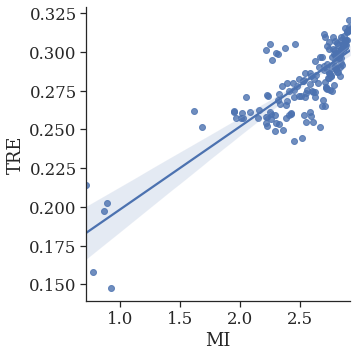

In [11]:
training_folder = "/home/luyuchen/work/tre/experiments/many_teach/"
logs = []


TRN_LOSS = 'trn_loss'
TRN_ACC = 'trn_acc'
VAL_LOSS = 'val_loss'
VAL_ACC = 'val_acc'
CVAL_ACC = 'cval_acc'
INFO_TX = 'MI'
ISOM = 'isom'
HOM = 'hom'
HOM_WO_MEAN = 'hom_wo_mean'
CHOM = 'c_hom'
LB = 'learnability'


for i in range(5):
    stats = parse_tb_event_files(os.path.join(training_folder, 'train/run{}'.format(i)))
    stats = {k: v.to_dict() for k, v in stats.items()}
    logs.append(stats)


# Create
sns.set(font_scale=1.5)
sns.set_style("ticks", {'font.family': 'serif'})
plt.tight_layout()

new_logs = []
new_logs = [[(epoch, info_x, tre, val_acc, lb, val_loss, tre_no_mean)
             for epoch, info_x, tre, val_acc, lb, val_loss, tre_no_mean in zip(log[LB]['steps'], log[INFO_TX]['values'],
                                                                               log[HOM]['values'], log[VAL_ACC]['values'],
                                                                               log[LB]['values'],
                                                                               log[VAL_LOSS]['values'],
                                                                               log[HOM_WO_MEAN]['values'])]
             for log in logs]

total_logs = []
for log in new_logs:
    info_max_step = np.argmax(log, 0)[1]
    val_max_step = np.argmax(log, 0)[3]
    loss_min_step = np.argmin(log, 0)[5]
    total_logs += log[:val_max_step]
data = pd.DataFrame(np.asarray(total_logs), columns=['epoch', 'MI', 'TRE', 'val_acc',
                                              'LB', 'val_loss', 'TRE_no_mean'])
tobeplot = ['LB', "TRE_no_mean",'MI', 'TRE']
for x_id in range(len(tobeplot)):
    for y_id in range(x_id + 1, len(tobeplot)):
        names = [tobeplot[x_id], tobeplot[y_id]]
        names = sorted(names)
        x_name, y_name = names
        sns.lmplot(x=x_name, y=y_name, data=data)
        print("pearson coeffcient {} {}: {}".format(
            x_name, y_name,
            scipy.stats.pearsonr(data[x_name], data[y_name])))

In [4]:
plot_logs = []
for log in new_logs:
    plot_log = {}
    for key_id, key in enumerate(['epoch', 'MI', 'TRE', 'val_acc', 'LB', 'val_loss', 'TRE_no_mean']):
        plot_log[key] = [data_point[key_id] for data_point in log]
    plot_logs.append(plot_log)

In [5]:
epoch = plot_logs[0]['epoch']

Text(0.5, 0, 'Epoch')

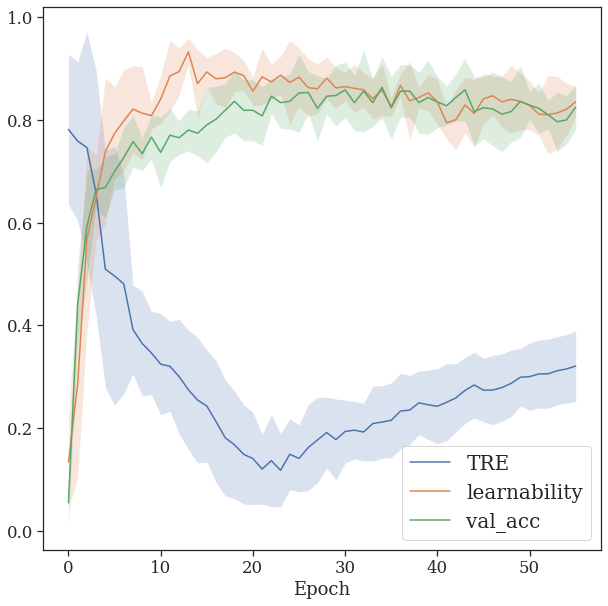

In [7]:
NAMES = {'TRE': 'TRE_jacob', 'TRE_no_mean': 'TRE', 'LB': 'learnability'}
fig, ax = plt.subplots(figsize=(10,10))
for tobeplot in [ 'TRE_no_mean',  'LB','val_acc']:
    values = [plot_log[tobeplot] for plot_log in plot_logs]
    values = np.array(values)
    values = (values - values.min()) / (values.max() - values.min())
    means = np.mean(values, 0)
    stds = np.std(values, 0)
    ax.plot(epoch, means, label=NAMES.get(tobeplot, tobeplot))
    ax.fill_between(epoch, means - stds, 
                    means + stds,
                    alpha=0.2)
ax.legend(loc='lower right', fontsize=20)
ax.set_xlabel('Epoch')

In [53]:
np.argmax(new_logs[0], 0)

array([40, 10,  5, 31, 16,  0,  0])

In [55]:
total_logs

[]